### importing modules

In [177]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 15

In [163]:
import numpy as np
import gym
from collections import deque
import random
import pickle
import time

In [164]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

### some constants and variables

In [165]:
# variables

discount = 0.9
epsilon = 0.1
memory_cap = 999999999

## classes for Replays

In [166]:
class Replay_Default():
    
    def __init__(self, buffer_size=50):
        self.buffer_size = buffer_size
        self.experience = deque(maxlen=memory_cap)
        
    def add_experience(self, s, a, r, s_next, terminal):
        self.experience.append([s, a, r, s_next, terminal])
        
    def experience_replay(self):
        min_buffer_len = np.min([len(self.experience), self.buffer_size])
        exp_batch = random.sample(self.experience, min_buffer_len)
        
        for s, a, r, s_next, terminal in exp_batch:
            q_update = r
            
            if not terminal:
                q_update = (r + discount * np.amax(self.clf.predict(s_next)[0]))
            
            q_vals = self.clf.predict(s)
            q_vals[0][a] = q_update
            self.clf.fit(s, q_vals, verbose=0)
            
    def reset(self):
        self.buffer_size = buffer_size
        self.experience = deque(maxlen=memory_cap)

In [167]:
class Replay_HER():
    
    def __init__(self, buffer_size=50):
        self.buffer_size = buffer_size
        self.experience = deque(maxlen=memory_cap)
        self.her_experience = deque(maxlen=memory_cap)
        
    def add_experience(self, s, a, r, s_next, terminal):
        self.experience.append([s, a, r, s_next, terminal])
        
    def add_her_experience(self, s, a, r, s_next, terminal):
        self.her_experience.append([s, a, r, s, terminal])
        
    def modify_her_list(self):
        new_her_experience = copy.deepcopy(self.her_experience)
        new_her_len = len(new_her_experience)
        her_goal = self.her_experience[-1][3]
        
        for i in range(new_her_len):
            new_her_experience[-1-i][0] = her_goal
            new_her_experience[-1-i][2] = -1.0
            new_her_experience[-1-i][3] = her_goal
            new_her_experience[-1-i][4] = False
            
            if (np.sum(np.abs((new_her_experience[-1-i][4] - her_goal))) == 0):
                new_her_experience[-1-i][2] = 0.0
                new_her_experience[-1-i][4] = True
        
        for hx in new_her_experience:
            self.experience.append(hx)
            
    def reset(self):
        self.buffer_size = buffer_size
        self.experience = deque(maxlen=memory_cap)
        self.her_experience = deque(maxlen=memory_cap)

In [168]:
class Replay_PER():
    
    def __init__(self, buffer_size=50):
        self.buffer_size = buffer_size
        self.experience = deque(maxlen=memory_cap)
        
    def add_experience(self, s, a, r, s_next, terminal):
        self.experience.append([s, a, r, s_next, terminal])
            
    def reset(self):
        self.buffer_size = buffer_size
        self.experience = deque(maxlen=memory_cap)

## class for DQN

In [169]:
# class DQN_old:
    
#     def __init__(self, o_space, a_space, lr):
#         self.a_space = a_space
#         self.lr = lr
        
#         self.clf = Sequential()
#         self.clf.add(Dense(64, input_shape=(o_space,), activation="relu"))
#         self.clf.add(Dense(64, activation="relu"))
#         self.clf.add(Dense(self.a_space, activation="linear"))
#         self.clf.compile(loss="mse", optimizer=Adam(lr=lr))
        
#     def get_action(self, s):
#         random_explore = np.random.rand()
        
#         if random_explore < epsilon:
#             return random.randrange(self.a_space)
        
#         q_vals = self.clf.predict(s)
        
#         return np.argmax(q_vals[0])
    
#     def experience_replay(self, replay):
#         min_buffer_len = np.min([len(replay.experience), replay.buffer_size])
#         exp_batch = random.sample(replay.experience, min_buffer_len)
        
#         for s, a, r, s_next, terminal in exp_batch:
#             q_update = r
            
#             if not terminal:
#                 q_update = (r + discount * np.amax(self.clf.predict(s_next)[0]))
            
#             q_vals = self.clf.predict(s)
#             q_vals[0][a] = q_update
#             self.clf.fit(s, q_vals, verbose=0)

In [170]:
# class DQN_Continuous:
    
#     def __init__(self, o_space, a_space, lr):
#         self.a_space = a_space
#         self.lr = lr
        
#         self.clf = Sequential()
#         self.clf.add(Dense(64, input_shape=(o_space,), activation="relu"))
#         self.clf.add(Dense(64, activation="relu"))
#         self.clf.add(Dense(self.a_space, activation="linear"))
#         self.clf.compile(loss="mse", optimizer=Adam(lr=lr))
        
#     def get_action(self, s):
#         random_explore = np.random.rand()
        
# #         if random_explore < epsilon:
# #             return random.randrange(self.a_space)
        
#         q_vals = self.clf.predict(s)
        
#         print(q_vals)
        
#         return q_vals[0]
    
#     def experience_replay(self, replay):
#         min_buffer_len = np.min([len(replay.experience), replay.buffer_size])
#         exp_batch = random.sample(replay.experience, min_buffer_len)
        
#         for s, a, r, s_next, terminal in exp_batch:
#             q_update = r
            
#             if not terminal:
#                 q_update = (r + discount * np.amax(self.clf.predict(s_next)[0]))
            
#             q_vals = self.clf.predict(s)
#             q_vals[0][a] = q_update
#             self.clf.fit(s, q_vals, verbose=0)

In [171]:
class DQN:
    
    def __init__(self, o_space, a_space, lr):
        self.a_space = a_space
        self.lr = lr
        
        self.clf = Sequential()
        self.clf.add(Dense(64, input_shape=(o_space,), activation="relu"))
        self.clf.add(Dense(64, activation="relu"))
        self.clf.add(Dense(self.a_space, activation="linear"))
        self.clf.compile(loss="mse", optimizer=Adam(lr=lr))
        
    def get_action(self, s):
        random_explore = np.random.rand()
        
        if random_explore < epsilon:
            return random.randrange(self.a_space)
        
        q_vals = self.clf.predict(s)
        
        return np.argmax(q_vals[0])
    
    def experience_replay(self, replay):
        min_buffer_len = np.min([len(replay.experience), replay.buffer_size])
        exp_batch = random.sample(replay.experience, min_buffer_len)
        
        s_update = []
        q_vals_update = []
        
        for s, a, r, s_next, terminal in exp_batch:
            q_update = r
            
            if not terminal:
                q_update = (r + discount * np.amax(self.clf.predict(s_next)[0]))
            
            q_vals = self.clf.predict(s)
            q_vals[0][a] = q_update
            
            s_update.append(s[0])
            q_vals_update.append(q_vals[0])

        s_update = np.array(s_update)
        q_vals_update = np.array(q_vals_update)
        self.clf.fit(s_update, q_vals_update, verbose=0)

### main

In [172]:
# learning_rates = [0.5, 0.1, 0.01, 0.001, 0.0001]
# buffers = [50, 100, 250, 500]
# methods = ['sarsa', 'exp_sarsa', 'q']
# seeds = np.arange(20)

# max_episodes = 100

# more doable (recommended by Veronica)

learning_rates = [0.1, 0.01, 0.001]
buffers = [50, 100, 250, 500]
methods = ['sarsa', 'exp_sarsa', 'q']
seeds = np.arange(5)
max_episodes = 100

# learning_rates = [0.1, 0.01, 0.001]
# learning_rates = [0.1, 0.01]
# buffers = [50]
# methods = ['exp_sarsa']
# seeds = np.arange(1)

# max_episodes = 25

In [173]:
# default values to start off with

buffer = 50
lr = 0.01
seed = 0
max_episodes = 500

In [174]:
%%time

print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('CartPole-v1')

if type(env.observation_space) == gym.spaces.discrete.Discrete:
    o_space = env.observation_space.n
elif type(env.observation_space) == gym.spaces.box.Box:
    o_space = env.observation_space.shape[0]

if type(env.action_space) == gym.spaces.discrete.Discrete:
    a_space = env.action_space.n
elif type(env.action_space) == gym.spaces.box.Box:
    a_space = env.action_space.shape[0]

replay = Replay_Default(buffer_size=buffer)
clf = DQN(o_space, a_space, lr)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])

    num_step = 0
    while True:
        num_step += 1
        a = clf.get_action(s)
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        replay.add_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break
    
    clf.experience_replay(replay)
        
    end = time.time()
    elapsed = end - start
    
#     print("elapsed", elapsed)

50 0.01 0
num_episode: 1; terminal_step: 31
num_episode: 2; terminal_step: 116
num_episode: 3; terminal_step: 45
num_episode: 4; terminal_step: 80
num_episode: 5; terminal_step: 84
num_episode: 6; terminal_step: 93
num_episode: 7; terminal_step: 67
num_episode: 8; terminal_step: 93
num_episode: 9; terminal_step: 53
num_episode: 10; terminal_step: 60
num_episode: 11; terminal_step: 63
num_episode: 12; terminal_step: 113
num_episode: 13; terminal_step: 46
num_episode: 14; terminal_step: 51
num_episode: 15; terminal_step: 36
num_episode: 16; terminal_step: 58
num_episode: 17; terminal_step: 38
num_episode: 18; terminal_step: 24
num_episode: 19; terminal_step: 40
num_episode: 20; terminal_step: 38
num_episode: 21; terminal_step: 49
num_episode: 22; terminal_step: 35
num_episode: 23; terminal_step: 19
num_episode: 24; terminal_step: 22
num_episode: 25; terminal_step: 68
num_episode: 26; terminal_step: 41
num_episode: 27; terminal_step: 26
num_episode: 28; terminal_step: 40
num_episode: 29; 

num_episode: 229; terminal_step: 180
num_episode: 230; terminal_step: 162
num_episode: 231; terminal_step: 168
num_episode: 232; terminal_step: 197
num_episode: 233; terminal_step: 261
num_episode: 234; terminal_step: 225
num_episode: 235; terminal_step: 187
num_episode: 236; terminal_step: 185
num_episode: 237; terminal_step: 205
num_episode: 238; terminal_step: 184
num_episode: 239; terminal_step: 188
num_episode: 240; terminal_step: 173
num_episode: 241; terminal_step: 182
num_episode: 242; terminal_step: 177
num_episode: 243; terminal_step: 169
num_episode: 244; terminal_step: 187
num_episode: 245; terminal_step: 221
num_episode: 246; terminal_step: 237
num_episode: 247; terminal_step: 244
num_episode: 248; terminal_step: 231
num_episode: 249; terminal_step: 270
num_episode: 250; terminal_step: 269
num_episode: 251; terminal_step: 248
num_episode: 252; terminal_step: 198
num_episode: 253; terminal_step: 214
num_episode: 254; terminal_step: 500
num_episode: 255; terminal_step: 500
n

num_episode: 452; terminal_step: 140
num_episode: 453; terminal_step: 150
num_episode: 454; terminal_step: 161
num_episode: 455; terminal_step: 161
num_episode: 456; terminal_step: 133
num_episode: 457; terminal_step: 152
num_episode: 458; terminal_step: 154
num_episode: 459; terminal_step: 184
num_episode: 460; terminal_step: 167
num_episode: 461; terminal_step: 156
num_episode: 462; terminal_step: 136
num_episode: 463; terminal_step: 166
num_episode: 464; terminal_step: 205
num_episode: 465; terminal_step: 128
num_episode: 466; terminal_step: 42
num_episode: 467; terminal_step: 28
num_episode: 468; terminal_step: 101
num_episode: 469; terminal_step: 134
num_episode: 470; terminal_step: 268
num_episode: 471; terminal_step: 125
num_episode: 472; terminal_step: 102
num_episode: 473; terminal_step: 115
num_episode: 474; terminal_step: 147
num_episode: 475; terminal_step: 183
num_episode: 476; terminal_step: 163
num_episode: 477; terminal_step: 316
num_episode: 478; terminal_step: 197
num

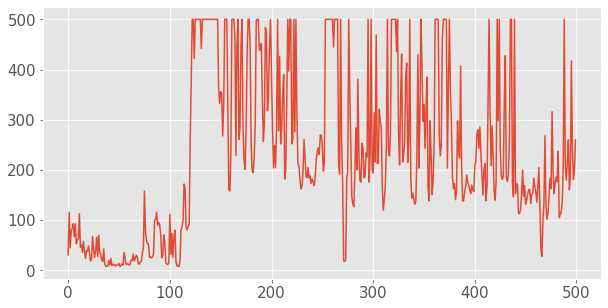

In [178]:
plt.plot(eps_steps)

### trying centipede ram

In [129]:
%%time

print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('Centipede-ram-v0')

if type(env.observation_space) == gym.spaces.discrete.Discrete:
    o_space = env.observation_space.n
elif type(env.observation_space) == gym.spaces.box.Box:
    o_space = env.observation_space.shape[0]

if type(env.action_space) == gym.spaces.discrete.Discrete:
    a_space = env.action_space.n
elif type(env.action_space) == gym.spaces.box.Box:
    a_space = env.action_space.shape[0]

replay = Replay_Default(buffer_size=buffer)
clf = DQN(o_space, a_space, lr)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])
    
#     print(s)

    num_step = 0
    while True:
        num_step += 1
        a = clf.get_action(s)
#         print(a)
        
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        replay.add_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break
    
    clf.experience_replay(replay)
        
    end = time.time()
    elapsed = end - start
    
#     print("elapsed", elapsed)

50 0.01 0
num_episode: 1; terminal_step: 634
num_episode: 2; terminal_step: 2493
num_episode: 3; terminal_step: 1069
num_episode: 4; terminal_step: 1034
num_episode: 5; terminal_step: 1137
num_episode: 6; terminal_step: 2528
num_episode: 7; terminal_step: 313
num_episode: 8; terminal_step: 1575
num_episode: 9; terminal_step: 722
num_episode: 10; terminal_step: 1208
num_episode: 11; terminal_step: 1530
num_episode: 12; terminal_step: 1016
num_episode: 13; terminal_step: 3359
num_episode: 14; terminal_step: 752
num_episode: 15; terminal_step: 1105
num_episode: 16; terminal_step: 1047
num_episode: 17; terminal_step: 1162
num_episode: 18; terminal_step: 1091
num_episode: 19; terminal_step: 930
num_episode: 20; terminal_step: 1354
num_episode: 21; terminal_step: 615
num_episode: 22; terminal_step: 926
num_episode: 23; terminal_step: 1067
num_episode: 24; terminal_step: 832
num_episode: 25; terminal_step: 737
num_episode: 26; terminal_step: 525
num_episode: 27; terminal_step: 1085
num_episod

KeyboardInterrupt: 

### trying bipedal

In [126]:
%%time

print(buffer, lr, seed)
np.random.seed(seed)

eps_steps = []
env = gym.make('BipedalWalker-v2')

if type(env.observation_space) == gym.spaces.discrete.Discrete:
    o_space = env.observation_space.n
elif type(env.observation_space) == gym.spaces.box.Box:
    o_space = env.observation_space.shape[0]

if type(env.action_space) == gym.spaces.discrete.Discrete:
    a_space = env.action_space.n
elif type(env.action_space) == gym.spaces.box.Box:
    a_space = env.action_space.shape[0]

replay = Replay_Default(buffer_size=buffer)
clf = DQN_Continuous(o_space, a_space, lr)

num_episode = 0

for num_episode in range(1, max_episodes+1):# while True:
    start = time.time()
    s = env.reset()
    s = np.reshape(s, [1, o_space])
    
#     print(s)

    num_step = 0
    while True:
        num_step += 1
        a = clf.get_action(s)
#         print(a)
        
        s_next, r, terminal, _ = env.step(a)
        s_next = np.reshape(s_next, [1, o_space])

        if terminal:
            r = -r
        else:
            r = r
        
        replay.add_experience(s, a, r, s_next, terminal)

        s = s_next

        if terminal:
            print("num_episode: {num_episode}; terminal_step: {num_step}".format(num_episode=num_episode, num_step=num_step))
            eps_steps.append(num_step)
            break
    
    clf.experience_replay(replay)
        
    end = time.time()
    elapsed = end - start
    
#     print("elapsed", elapsed)

50 0.01 0
[[-0.27184     0.08046675 -0.8792407   0.25806314]]
[[-0.12367591  0.19607183 -1.1219536   0.20948043]]
[[-0.39700043  0.17220363 -1.0094624   0.36819226]]
[[-0.30009347  0.14226368 -0.7711625   0.21087569]]
[[-0.22486192  0.12246545 -0.72722745  0.17922358]]
[[-0.16960578  0.09976108 -0.6820135   0.16585375]]
[[-0.08948356  0.06586005 -0.6784136   0.13449807]]
[[-0.17442152 -0.04373078 -0.6007785   0.19736446]]
[[-0.17035672 -0.04887591 -0.5956231   0.20076944]]
[[-0.17489706 -0.04768292 -0.5857389   0.2060935 ]]
[[-0.18111151 -0.04100851 -0.5769987   0.20105128]]
[[-0.17709784 -0.03381699 -0.5725967   0.19382946]]
[[-0.35485908 -0.22057097 -0.7685286   0.26539376]]
[[-0.24826545 -0.14833997 -0.6791919   0.16839719]]
[[-0.22268176 -0.14927119 -0.6758682   0.16492075]]
[[-0.17225966 -0.11436394 -0.6685888   0.22473435]]
[[-0.18398345 -0.15209503 -0.6726289   0.14670369]]
[[-0.1174937  -0.10103374 -0.66846234  0.20253879]]
[[-0.09793235 -0.09767053 -0.66298574  0.18145016]]
[[

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
##################################